In [1]:
# ## Simulation parameters
exp_name = 'exp-FINAL'
eps = 0.10
eps_str = '0_1'

run_idx_length = 1_000
N_val = 1_000
runs = 50

In [19]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial']
%config InlineBackend.figure_formats = ['svg']

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import itertools
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import metrics
import itertools

import joblib
from joblib import Parallel, delayed

In [5]:
from OPE_utils_new import (
    format_data_tensor,
    policy_eval_analytic_finite,
    OPE_IS_h,
    compute_behavior_policy_h,
)

In [6]:
def policy_eval_helper(π):
    V_H = policy_eval_analytic_finite(P.transpose((1,0,2)), R, π, gamma, H)
    Q_H = [(R + gamma * P.transpose((1,0,2)) @ V_H[h]) for h in range(1,H)] + [R]
    J = isd @ V_H[0]
    # Check recursive relationships
    assert len(Q_H) == H
    assert len(V_H) == H
    assert np.all(Q_H[-1] == R)
    assert np.all(np.sum(π * Q_H[-1], axis=1) == V_H[-1])
    assert np.all(R + gamma * P.transpose((1,0,2)) @ V_H[-1] == Q_H[-2])
    return V_H, Q_H, J

In [7]:
def iqm(x):
    return scipy.stats.trim_mean(x, proportiontocut=0.25, axis=None)

In [8]:
NSTEPS = H = 20   # max episode length in historical data # Horizon of the MDP
G_min = -1        # the minimum possible return
G_max =  1        # the maximum possible return
nS, nA = 1442, 8

PROB_DIAB = 0.2

In [9]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

In [10]:
# Precomputed optimal policy
π_star = joblib.load('../data/π_star.joblib')

## Policies

In [11]:
# vaso unif, mv abx optimal
π_unif = (np.tile(π_star.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)

### Behavior policy

In [12]:
# vaso eps=0.5, mv abx optimal
π_beh = (np.tile(π_star.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)
π_beh[π_star == 1] = 1-eps
π_beh[π_beh == 0.5] = eps

In [13]:
V_H_beh, Q_H_beh, J_beh = policy_eval_helper(π_beh)
J_beh

0.25038354793851164

### Optimal policy

In [14]:
V_H_star, Q_H_star, J_star = policy_eval_helper(π_star)
J_star

0.40877179296760224

### flip action for x% states

In [15]:
def get_π_flip(pol_flip_seed, pol_flip_num):
    rng_flip = np.random.default_rng(pol_flip_seed)
    flip_states = rng_flip.choice(range(1440), pol_flip_num, replace=False)

    π_tmp = (np.tile(π_star.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)
    π_flip = π_tmp.copy()
    π_flip[π_tmp == 0.5] = 0
    π_flip[π_star == 1] = 1
    for s in flip_states:
        π_flip[s, π_tmp[s] == 0.5] = 1
        π_flip[s, π_star[s] == 1] = 0
    assert π_flip.sum(axis=1).mean() == 1
    return π_flip

In [16]:
πs_flip_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        π_flip = get_π_flip(flip_seed, flip_num)
        πs_flip_list.append(π_flip)

In [17]:
v_list = []
for π_eval in tqdm(πs_flip_list):
    _, _, J_eval = policy_eval_helper(π_eval)
    v_list.append(J_eval)

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:15<00:00,  1.69it/s]


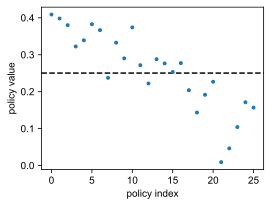

In [204]:
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(v_list, ls='none', marker='.')
plt.axhline(J_beh, c='k', ls='--', label='behavior', zorder=0)
plt.xlabel('policy index')
plt.ylabel('policy value')
plt.savefig('fig/sepsisSim-policies.pdf', bbox_inches='tight')
plt.show()

## Load results

In [21]:
df_results_0 = pd.read_csv(f'./results/{exp_name}/vaso_eps_{eps_str}-observed.csv')

In [68]:
dfs_results_Naive_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-1/vaso_eps_{eps_str}-{pol_name}-aug_step-Naive.csv')
        dfs_results_Naive_list.append(df_results_)

In [50]:
dfs_results_NaiveUW_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-1/vaso_eps_{eps_str}-{pol_name}-aug_step-NaiveUW.csv')
        dfs_results_NaiveUW_list.append(df_results_)

In [51]:
dfs_results_orig_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-1/vaso_eps_{eps_str}-{pol_name}-orig.csv')
        dfs_results_orig_list.append(df_results_)

In [75]:
dfs_results_annotEval_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-2/vaso_eps_{eps_str}-{pol_name}-aug_step-annotEval.csv')
        dfs_results_annotEval_list.append(df_results_)

In [162]:
dfs_results_annotBeh_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-2/vaso_eps_{eps_str}-{pol_name}-aug_step-annotBeh.csv')
        dfs_results_annotBeh_list.append(df_results_)

In [161]:
dfs_results_annotZero_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-2/vaso_eps_{eps_str}-{pol_name}-aug_step-annotZero.csv')
        dfs_results_annotZero_list.append(df_results_)

In [163]:
dfs_results_annotBehConvertedAM_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-5/vaso_eps_{eps_str}-{pol_name}-aug_step-annotBehConvertedAM.csv')
        dfs_results_annotBehConvertedAM_list.append(df_results_)

## Plots

In [164]:
exp_idx = 0
π_eval = πs_flip_list[exp_idx]
J_eval = v_list[exp_idx]
df_results_orig = dfs_results_orig_list[exp_idx]
df_results_Naive = dfs_results_Naive_list[exp_idx]
df_results_NaiveUW = dfs_results_NaiveUW_list[exp_idx]
df_results_annotEval = dfs_results_annotEval_list[exp_idx]
df_results_annotBeh = dfs_results_annotBeh_list[exp_idx]
df_results_annotZero = dfs_results_annotZero_list[exp_idx]
df_results_annotBehConvertedAM = dfs_results_annotBehConvertedAM_list[exp_idx]

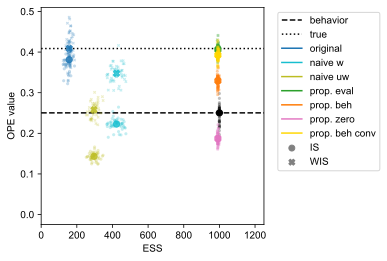

In [166]:
fig, ax = plt.subplots(figsize=(4,4))
plt.axhline(J_beh, c='k', ls='--', label='behavior', zorder=0)
plt.scatter(N_val, J_beh, marker='o', s=40, c='k', alpha=1)
plt.axhline(J_eval, c='k', ls=':', label='true', zorder=0)
plt.scatter([N_val]*runs, df_results_0['IS_value'], 
            marker='o', s=10, c='k', alpha=0.25, ec='none')

for df, name, color in [
    [df_results_orig, 'original', 'tab:blue'],
    [df_results_Naive, 'naive w', 'tab:cyan'],
    [df_results_NaiveUW, 'naive uw', 'tab:olive'],
    [df_results_annotEval, 'prop. eval', 'tab:green'],
    [df_results_annotBeh, 'prop. beh', 'tab:orange'],
    [df_results_annotZero, 'prop. zero', 'tab:pink'],
    [df_results_annotBehConvertedAM, 'prop. beh conv', 'gold'],
]:
    plt.plot(0,0, c=color, label=name)
    plt.scatter(df['ESS1'], df['IS_value'], marker='o', s=10, c=color, alpha=0.25, ec='none')
    plt.scatter(iqm(df['ESS1']), iqm(df['IS_value']), marker='o', s=40, c=color, alpha=0.8)
    plt.scatter(df['ESS1'], df['WIS_value'], marker='X', s=10, c=color, alpha=0.25, ec='none')
    plt.scatter(iqm(df['ESS1']), iqm(df['WIS_value']), marker='X', s=40, c=color, alpha=0.8)

plt.scatter(-100,0, c='gray', marker='o', label='IS')
plt.scatter(-100,0, c='gray', marker='X', label='WIS')
plt.xlabel('ESS')
plt.ylabel('OPE value')
# plt.ylim(0.1, 0.7)
plt.xlim(0, N_val*1.25)
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

## Metrics

In [34]:
def rmse(y1, y2):
    return np.sqrt(np.mean(np.square(y1-y2)))

In [35]:
def compute_confmat(J_eval, v_est_list):
    confmat = np.zeros((2,2))
    confmat[int(J_eval >= J_beh), 0] += (v_est_list < df_results_0['IS_value'].iloc[:len(v_est_list)]).sum()
    confmat[int(J_eval >= J_beh), 1] += (v_est_list >= df_results_0['IS_value'].iloc[:len(v_est_list)]).sum()
    return confmat

In [149]:
def compute_confmat_batch(v_list, v_est_list, v_beh):
    confmat = np.zeros((2,2))
    for J_eval, v_est in zip(v_list, v_est_list):
        confmat[int(J_eval >= J_beh), 0] += (v_est < v_beh).sum()
        confmat[int(J_eval >= J_beh), 1] += (v_est >= v_beh).sum()
    return confmat

In [168]:
all_results = {}
for name, df_results_lists in {
    'orig': dfs_results_orig_list,
    'naive uw': dfs_results_NaiveUW_list,
    'naive w': dfs_results_Naive_list,
    'annotEval': dfs_results_annotEval_list, 
    'annotBeh': dfs_results_annotBeh_list,
    'annotZero': dfs_results_annotZero_list,
    'annotBehConvertedAM': dfs_results_annotBehConvertedAM_list,
}.items():
    print('===', name)
    v_IS = []
    v_WIS = []
    v_ESS = []
    for π_eval, df_results_ in zip(πs_flip_list, df_results_lists):
        v_IS.append(df_results_['IS_value'])
        v_WIS.append(df_results_['WIS_value'])
        v_ESS.append(df_results_['ESS1'])
    print('ESS:', np.mean(v_ESS))
    
    v_est_list = v_IS + v_WIS
    rmse_value = [rmse(l, np.array(v_list+v_list)) for l in np.array(v_est_list).T]
    print('RMSE: {:.3f}±{:.3f}'.format(np.mean(rmse_value).round(3), np.std(rmse_value).round(3)))
    
    spearman_corr = [scipy.stats.spearmanr(l, np.array(v_list+v_list)).correlation for l in np.array(v_est_list).T]
    print('Spearman: {:.3f}±{:.3f}'.format(np.mean(spearman_corr).round(3), np.std(spearman_corr).round(3)))
    
    confmats_ = [compute_confmat_batch(v_list+v_list, l, vb) for l,vb in zip(np.array(v_est_list).T, df_results_0['IS_value'])]
    confmat_sum = sum(confmats_)
    (accuracy, fpr, fnr) = (
        [(cm[0,0]+cm[1,1])/np.sum(cm) for cm in confmats_],
        [cm[0,1]/(cm[0,0]+cm[0,1]) for cm in confmats_], 
        [cm[1,0]/(cm[1,0]+cm[1,1]) for cm in confmats_],
    )
    print('Accuracy: {:.1%}±{:.1%} \t FPR: {:.1%}±{:.1%} \t FNR: {:.1%}±{:.1%}'.format(
        np.mean(accuracy), np.std(accuracy), 
        np.mean(fpr), np.std(fpr), 
        np.mean(fnr), np.std(fnr), 
    ))
    display(pd.DataFrame(
        (confmat_sum).astype(int), 
        index=['$$v(\pi_e) < v(\pi_b)$$', '$$v(\pi_e) \geq v(\pi_b)$$'],
        columns=['$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$', '$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$'],
    ).rename_axis(index='True Ranking', columns=f'{name} Predicted Ranking')\
            .style.background_gradient(cmap='Blues', vmin=0, vmax=1500))
    
    all_results[name] = {
        'spearman': spearman_corr,
        'rmse': rmse_value,
        'accuracy': accuracy,
        'fpr': fpr,
        'fnr': fnr,
        'ess': v_ESS,
    }

=== orig
ESS: 76.82151971964208
RMSE: 0.113±0.038
Spearman: 0.596±0.110
Accuracy: 76.5%±3.5% 	 FPR: 33.7%±8.7% 	 FNR: 15.9%±4.6%


orig Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,729,371
$$v(\pi_e) \geq v(\pi_b)$$,239,1261


=== naive uw
ESS: 207.20357031115466
RMSE: 0.128±0.006
Spearman: 0.089±0.089
Accuracy: 50.0%±6.0% 	 FPR: 11.6%±8.3% 	 FNR: 78.1%±13.6%


naive uw Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,972,128
$$v(\pi_e) \geq v(\pi_b)$$,1171,329


=== naive w
ESS: 300.7636760863779
RMSE: 0.097±0.006
Spearman: 0.420±0.097
Accuracy: 64.3%±4.7% 	 FPR: 24.0%±12.7% 	 FNR: 44.3%±11.4%


naive w Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,836,264
$$v(\pi_e) \geq v(\pi_b)$$,664,836


=== annotEval
ESS: 993.9926736346977
RMSE: 0.013±0.005
Spearman: 0.995±0.003
Accuracy: 95.7%±3.1% 	 FPR: 4.5%±6.9% 	 FNR: 4.2%±5.3%


annotEval Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1050,50
$$v(\pi_e) \geq v(\pi_b)$$,63,1437


=== annotBeh
ESS: 993.9926736346977
RMSE: 0.070±0.003
Spearman: 0.961±0.011
Accuracy: 86.8%±8.2% 	 FPR: 20.0%±20.1% 	 FNR: 8.2%±11.3%


annotBeh Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,880,220
$$v(\pi_e) \geq v(\pi_b)$$,123,1377


=== annotZero
ESS: 993.9926736346977
RMSE: 0.166±0.008
Spearman: 0.925±0.016
Accuracy: 42.3%±0.0% 	 FPR: 0.0%±0.0% 	 FNR: 100.0%±0.0%


annotZero Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1100,0
$$v(\pi_e) \geq v(\pi_b)$$,1500,0


=== annotBehConvertedAM
ESS: 993.9926736346977
RMSE: 0.028±0.007
Spearman: 0.979±0.010
Accuracy: 90.1%±5.4% 	 FPR: 4.2%±6.6% 	 FNR: 14.1%±9.7%


annotBehConvertedAM Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1054,46
$$v(\pi_e) \geq v(\pi_b)$$,212,1288


In [185]:
df_all_results = pd.DataFrame(all_results).T
df_all_results_mean = df_all_results.applymap(np.mean)
df_all_results_std = df_all_results.applymap(np.std)

In [201]:
df_all_results_summary = pd.DataFrame()
df_all_results_summary['rmse'] = \
    df_all_results_mean['rmse'].apply(lambda x: '{:.3f}'.format(x)) \
    .str.cat(df_all_results_std['rmse'].apply(lambda x: '{:.3f}'.format(x)), sep='±')
df_all_results_summary['ess'] = \
    df_all_results_mean['ess'].apply(lambda x: '{:.1f}'.format(x)) \
    .str.cat(df_all_results_std['ess'].apply(lambda x: '{:.1f}'.format(x)), sep='±')
df_all_results_summary['spearman'] = \
    df_all_results_mean['spearman'].apply(lambda x: '{:.3f}'.format(x)) \
    .str.cat(df_all_results_std['spearman'].apply(lambda x: '{:.3f}'.format(x)), sep='±')
df_all_results_summary['accuracy'] = \
    df_all_results_mean['accuracy'].apply(lambda x: '{:.1f}'.format(x*100)) \
    .str.cat(df_all_results_std['accuracy'].apply(lambda x: '{:.1f}'.format(x*100)), sep='±')
df_all_results_summary['fpr'] = \
    df_all_results_mean['fpr'].apply(lambda x: '{:.1f}'.format(x*100)) \
    .str.cat(df_all_results_std['fpr'].apply(lambda x: '{:.1f}'.format(x*100)), sep='±')
df_all_results_summary['fnr'] = \
    df_all_results_mean['fnr'].apply(lambda x: '{:.1f}'.format(x*100)) \
    .str.cat(df_all_results_std['fnr'].apply(lambda x: '{:.1f}'.format(x*100)), sep='±')

In [202]:
df_all_results_summary[[
    'rmse', 'ess', 'spearman', 'accuracy', 'fpr', 'fnr'
]]

,rmse,ess,spearman,accuracy,fpr,fnr
orig,0.113±0.038,76.8±44.0,0.596±0.110,76.5±3.5,33.7±8.7,15.9±4.6
naive uw,0.128±0.006,207.2±91.5,0.089±0.089,50.0±6.0,11.6±8.3,78.1±13.6
naive w,0.097±0.006,300.8±117.6,0.420±0.097,64.3±4.7,24.0±12.7,44.3±11.4
annotEval,0.013±0.005,994.0±10.1,0.995±0.003,95.7±3.1,4.5±6.9,4.2±5.3
annotBeh,0.070±0.003,994.0±10.1,0.961±0.011,86.8±8.2,20.0±20.1,8.2±11.3
annotZero,0.166±0.008,994.0±10.1,0.925±0.016,42.3±0.0,0.0±0.0,100.0±0.0
annotBehConvertedAM,0.028±0.007,994.0±10.1,0.979±0.010,90.1±5.4,4.2±6.6,14.1±9.7
